In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

/home/evan/.local/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/evan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
                                
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

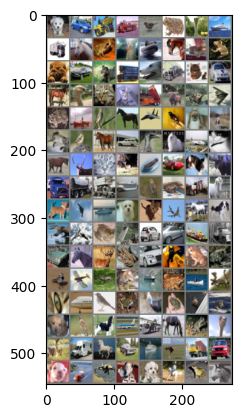

dog   car   truck truck bird  frog  bird  ship  truck horse frog  cat   ship  horse cat   frog  dog   car   dog   truck dog   truck cat   car   horse bird  cat   cat   truck deer  deer  plane frog  ship  bird  horse plane bird  dog   horse cat   bird  horse car   bird  dog   plane cat   horse deer  cat   deer  ship  car   dog   dog   truck truck truck ship  bird  cat   truck horse dog   plane ship  dog   cat   plane horse dog   deer  plane frog  truck car   car   ship  truck car   horse deer  frog  car   cat   frog  frog  bird  plane deer  cat   ship  frog  ship  deer  cat   plane bird  frog  bird  frog  cat   cat   dog   bird  dog   plane truck horse frog  bird  deer  truck horse car   ship  bird  truck car   dog   ship  plane cat   dog   horse frog  horse


In [5]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
from resnet import ResNet

In [7]:
net = ResNet()
net = net.to(device)

In [8]:
optim = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
lossi = []
testi = []

In [10]:
def estimate_loss(split="train"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
    return loss / len(loader)

In [11]:
epochs = 16

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optim.zero_grad()
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        lossi.append(loss.item())
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'[{epoch}, {i}] loss: {loss.item()}')

    test_loss = estimate_loss("test")
    print(f'[{epoch}] test loss: {test_loss}')
    testi.append(test_loss)


[0, 0] loss: 2.3419055938720703
[0, 200] loss: 1.4971166849136353
[0] test loss: 1.2854512507402445
[1, 0] loss: 1.3380703926086426
[1, 200] loss: 1.1485388278961182
[1] test loss: 1.0829020964948437
[2, 0] loss: 0.9139939546585083
[2, 200] loss: 0.9266820549964905
[2] test loss: 0.9558995569808574
[3, 0] loss: 0.8722485899925232
[3, 200] loss: 0.9029671549797058
[3] test loss: 0.8775386033178885
[4, 0] loss: 0.8429587483406067
[4, 200] loss: 0.763989269733429
[4] test loss: 0.8417171828354462
[5, 0] loss: 0.8205925226211548
[5, 200] loss: 0.7621330618858337
[5] test loss: 0.7779873873614058
[6, 0] loss: 0.7005522847175598
[6, 200] loss: 0.5984466671943665
[6] test loss: 0.7501756382893913
[7, 0] loss: 0.7622902989387512
[7, 200] loss: 0.7587293982505798
[7] test loss: 0.6709035974514636
[8, 0] loss: 0.4529091715812683
[8, 200] loss: 0.4841459393501282
[8] test loss: 0.679312847083128
[9, 0] loss: 0.5166464447975159
[9, 200] loss: 0.5150073170661926
[9] test loss: 0.6546557115603097
[1

In [12]:
def check_accuracy(split="test"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    net.train()
    print(f'{split} accuracy: {correct / total}')
    return correct / total

check_accuracy("test")
check_accuracy("train")

Training accuracy: 0.92888


0.92888

In [ ]:
import matplotlib.pyplot as plt

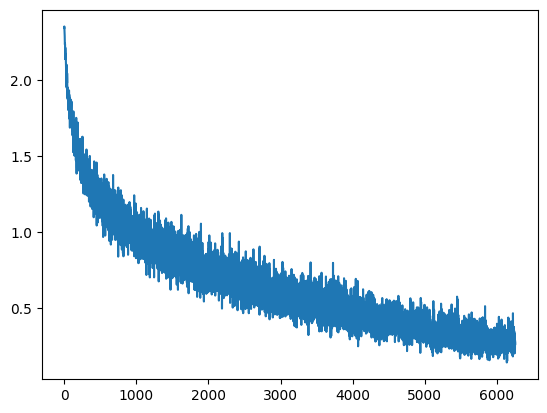

In [13]:
plt.plot(lossi)

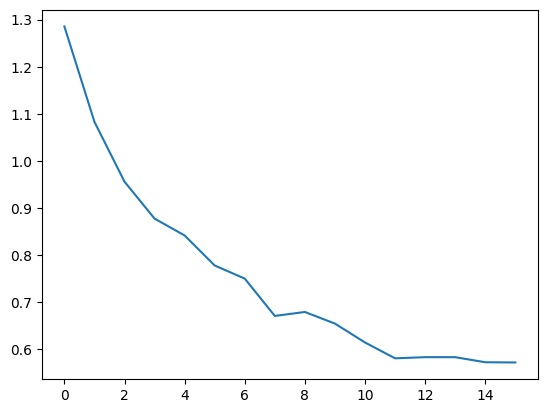

In [15]:
plt.plot(testi)